<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg"  width=400></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

In [0]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch

### 1. Нахождение сложной производной

Найдите производную по x от функции 
$$\sin\left(\tan(x)\frac{x^2}{y} + \ln(e^{-x^2 + 3}+x^3y)\right)\tan(x^2e^{x^9})$$

При этом надо пользоваться встроенным в PyTorch autograd. Численное вычисление производной может не дать нужный результат.

In [10]:
def find_x_derivative(x, y):
    x = torch.tensor(data=x, dtype=torch.float, requires_grad=True)
    y = torch.tensor(data=y, dtype=torch.float, requires_grad=True)
    res = torch.sin( torch.tan(x)*(x * x / y) + torch.log(torch.exp(-x * x + 3) + x * x * x * y) ) * torch.tan( x * x * (torch.exp(x**9)))
    res.backward()

    return x.grad

find_x_derivative(1, 21)

tensor(-9.0207)

# 2. Нахождение косинусной близости

Вам даны две матрицы A и B. Необходимо посчитать косинусную близость между строчками матрицы A и столбцами матрицы B. Ответ - матрица чисел, где номер строки - номер строки из матрицы А, а номер столбца - номер столбца из В, от которых бралась косинусная близость.

Напомним, что косинусная близость двух векторов - косинус угла между ними. В n-мерном пространстве косинус угла между веткорами удобнее всего через скалярное произведение:
$$\cos(angle(x, y)) = \frac{x \cdot y}{\left\|x\right\| \left\|y\right\|}$$

(Наша операция очень похожа на умножение матриц)

In [0]:
def get_cos_sim(A, B):
    """
        A, B - torch float tensors
    """
    res = torch.mm(a,b)/(torch.norm(a, dim = 1, keepdim = True) * torch.norm(b, dim = 0, keepdim = True))

    return res

In [17]:
a = torch.FloatTensor([[1, -47, 25, -3], [10, 17, -15, 22], [-3, -7, 26, 36], [12, -27, -42, 0]])
b = torch.FloatTensor([[-50, -13, 1, 10, 1242], [21, 48, -13, -14, -20], [20, 15, 11, 43, 11], [11, 103, 147, 27, -8]])
torch.mean(get_cos_sim(a, b))

tensor([[-0.1817, -0.3581,  0.0565,  0.5813,  0.0375],
        [-0.1031,  0.7134,  0.5828, -0.1064,  0.2852],
        [ 0.3467,  0.7313,  0.8498,  0.8934, -0.0641],
        [-0.6642, -0.3515, -0.0130, -0.4751,  0.2349]])
tensor([[-0.1817, -0.3581,  0.0565,  0.5813,  0.0375],
        [-0.1031,  0.7134,  0.5828, -0.1064,  0.2852],
        [ 0.3467,  0.7313,  0.8498,  0.8934, -0.0641],
        [-0.6642, -0.3515, -0.0130, -0.4751,  0.2349]])


tensor(0.1498)

# 3. Линейная регрессия

Раньше мы самостоятельно считали производные, чтобы находить веса линейной регрессии с помощью градиентного спуска. Теперь нам нужно использовать для этого PyTorch и его autograd. 

**Важно**: на самом деле .backward не обновляет содержимое матриц с производными (some_tensor.grad), а прибавляет к ним только что посчитаные значения проивзодных. Это значит, что вызвав .backward дважды, вы получите удвоенную производную. Так как мы обновляем веса в цикле и много раз вызываем .backward, то очень быстро мы получим мусор в some_tensor.grad, если не будем его каждый раз обнулять. Таким образом, в конц итериации после использования производных обнулите значения в матрице производных для всех нужных Вам переменных. Делается это вот так 
> some\_tensor.grad.data.zero_()

In [0]:
class LinearRegression:
    def get_loss(self, preds, y):
        """
            @param preds: предсказания модели
            @param y: истиные значения
            @return mse: значение MSE на переданных данных
        """
        # возьмите средний квадрат ошибки по всем выходным переменным
        # то есть сумму квадратов ошибки надо поделить на количество_элементов * количество_таргетов
        loss = preds - y
        # print(preds)
        # print(y)
        # print(loss.numel())
        # raise Exception("File is empty")
        return torch.sum(loss * loss) / loss.numel()
    
    def init_weights(self, input_size, output_size):
        """
            Инициализирует параметры модели
            W - матрица размерности (input_size, output_size)
            инициализируется рандомными числами из
            uniform распределения (torch.rand())
            b - вектор размерности (1, output_size)
            инициализируется нулями
        """
        torch.manual_seed(0) #необходимо для воспроизводимости результатов
        self.W = torch.rand(input_size, output_size,  requires_grad=True)
        self.b = torch.zeros(1, output_size, requires_grad=True)

    def fit(self, X, y, num_epochs=1000, lr=0.001):
        """
            Обучение модели линейной регрессии методом градиентного спуска
            @param X: размерности (num_samples, input_shape)
            @param y: размерности (num_samples, output_shape)
            @param num_epochs: количество итераций градиентного спуска
            @param lr: шаг градиентного спуска
            @return metrics: вектор значений MSE на каждом шаге градиентного
            спуска.
        """
        self.init_weights(X.shape[1], y.shape[1])
        print(self.W.shape)
        print(self.W)
        metrics = []
        for _ in range(num_epochs):
            preds = self.predict(X)
            # сделайте вычисления градиентов c помощью Pytorch и обновите веса
            # осторожнее, оберните вычитание градиента в 
#                 with torch.no_grad():
#                     #some code
            # иначе во время прибавления градиента к переменной создастся очень много нод в дереве операций
            # и ваши модели в будущем будут падать от нехватки памяти
            self.get_loss(preds, y).backward()
            with torch.no_grad():
              self.W -= self.W.grad * lr
              self.b -= self.b.grad * lr
              self.W.grad.zero_()
              self.b.grad.zero_()
            metrics.append(self.get_loss(preds, y).data)
        return metrics

    def predict(self, X):
        """
            Думаю, тут все понятно. Сделайте свои предсказания :)
        """
        return X @ self.W + self.b

1. Сгенерируйте данные с помощью make_regression с параметрами n_targets=3, n_features=2, noise=10, random_state=42. 
2. Обучите модель линейной регрессии, оставив в fit параметры num_epochs и lr по умолчанию (обратите внимание, что перед обучением нужно привести данные к типу, использующимся в torch) 
2. Посчитайте среднее значение метрики MSE по всем итерациям цикла в fit (массив из значений MSE на каждой итерации возвращается из метода fit). Ответом, который необходимо сдать в систему, будет число, округленное до 3х знаков после запятой.

In [33]:
X, Y = datasets.make_regression(n_targets = 3, n_features = 2, noise = 10, random_state = 42)
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()
# print(X, Y)
model = LinearRegression()
mse = model.fit(X, Y)

torch.Size([2, 3])
tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341]], requires_grad=True)


In [34]:
print(np.mean(mse))

4256.561


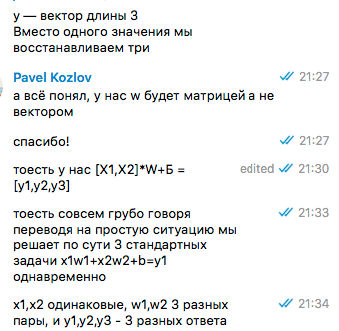

Здесь предлагаем протестировать метод predict удобным вам образом.

In [0]:
#YOUR CODE